# Ebisu with Generalized Beta Distributions

It turns out that the time-shifted Beta distributions used in Ebisu correspond to a known probability distribution: the [Generalized Beta Distribution of the First Kind (GB1)](https://en.wikipedia.org/wiki/Generalized_beta_distribution#Generalized_beta_of_first_kind_(GB1)).
Using this distribution can simplify some of the updates and introduce fewer approximations.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas
from scipy.special import gammaln
from scipy import integrate, optimize, special, stats

import ebisu

plt.style.use('seaborn-darkgrid')


## Quick Updates

I'd like to see what the Ebisu algorithm would have to say about my current log of Anki reviews.
Because Anki wasn't using the Ebisu algorithm to schedule reviews, sometimes reviews of the same note happen in quick succession.
I suspect that this may cause a problem in Ebisu's algorithm, which uses the interval between the last two reviews as the reference time to project out a Beta distribution to future times.

/home/rkern/.edm/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]
/home/rkern/git/ebisu/ebisu/alternate.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  cdfPercentile = lambda p: betainc(alpha, beta, p**(1 / dt)) - percentile


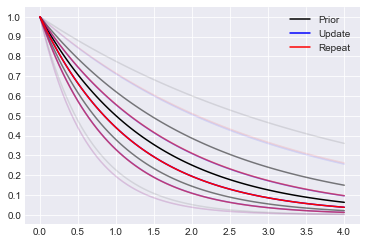

In [2]:
def plot_decay(prior, ts, color='black', label=None, qs=(0.05, 0.25, 0.5, 0.75, 0.95)):
    rows = []
    for t in ts:
        row = []
        for q in qs:
            row.append(ebisu.alternate.predictRecallMedian(prior, t, q))
        rows.append(row)
    scores = np.asarray(rows).T
    for i, (q, score) in enumerate(zip(qs, scores)):
        alpha = 1.0 - 2*abs(q - 0.5)
        plt.plot(ts, score, color=color, alpha=alpha, label=label if q == 0.5 else None)

ts = np.linspace(0.0, 4.0, 81.0)

# Standard initial model with a half-life at time 1.0 (arbitrary units)
model0 = (4.0, 4.0, 1.0)
# Let's review and observe a negative recall at the half-life.
model1 = ebisu.updateRecall(model0, False, 1.0)
# Now let's review and observe a positive recall very quickly after that.
# Let's say that Anki made me re-test very soon after my failure.
model2 = ebisu.updateRecall(model1, True, 0.01)

plot_decay(model0, ts, label='Prior')
plot_decay(model1, ts, color='blue', label='Update')
plot_decay(model2, ts, color='red', label='Repeat')
plt.yticks(np.linspace(0.0, 1.0, 11));
plt.legend();

The `Repeat` decay used to show severe numerical issues.
However, the method for predicting the future quantiles [was fixed](https://github.com/fasiha/ebisu/commit/91538b966b532a503de9662247aa990e47ff58d2), so the graph looks right.
Nonetheless, let's carry on and find ways to improve the model.

In [10]:
def simulate_probs(model, tnow, size, random_state=np.random):
    """Draw a given number of time-evolved Bernoulli probabilities.
    """
    alpha, beta, t0 = model
    delta = tnow / t0
    q = stats.beta.rvs(alpha, beta, size=size, random_state=random_state)
    p = q ** delta
    return p

def simulate_posterior(model, tnow, obs, size, random_state=np.random):
    """Rejection algorithm for simulating the posterior given an observation at time `tnow`.
    """
    matching_draws = []
    while len(matching_draws) < size:
        # Draw time-evolved p values, then conduct Bernoulli trials.
        p = simulate_probs(model, tnow, size, random_state=random_state)
        matching = (random_state.random_sample(size) < p) == obs
        # Keep those that match the observation.
        matching_draws.extend(p[matching])
    matching_draws = np.asarray(matching_draws[:size])
    return matching_draws

def genbeta1_pdf(x, alpha, beta, delta):
    """PDF of the GB1 distribution.
    """
    y = np.power(x, 1/delta)
    with np.errstate(invalid='ignore', divide='ignore'):
        logz = stats.beta.logpdf(y, alpha, beta) + np.log(y) - np.log(x) - np.log(delta)
        logz[x == 0] = -np.inf  # not always right, but usually.
    return np.exp(logz)

def plot_genbeta1(model, tnow, **kwds):
    """Plot the GB1 distribution implied by evolving the model for a given time.
    """
    x = np.linspace(0.0, 1.0, 101)
    alpha, beta, t0 = model
    delta = tnow / t0
    y = genbeta1_pdf(x, alpha, beta, delta)
    kwds.setdefault('color', 'black')
    plt.plot(x, y, **kwds)

def posterior_pdf(prior, tnow, obs):
    """PDF of the posterior.
    
    The normalization constant is estimated by numerical integration.
    """
    x = np.linspace(0.0, 1.0, 101)
    alpha, beta, t0 = prior
    delta = tnow / t0
    prior_pdf = genbeta1_pdf(x, alpha, beta, delta)
    if obs:
        posterior_pdf = prior_pdf * x
    else:
        posterior_pdf = prior_pdf * (1 - x)
    Z = integrate.trapz(posterior_pdf, x)
    posterior_pdf /= Z
    return x, posterior_pdf

def plot_posterior_pdf(model, tnow, obs):
    x, posterior = posterior_pdf(model, tnow, obs)
    plt.plot(x, posterior, 'r-')

def _subtractexp(x, y):
    """Evaluates exp(x) - exp(y) a bit more accurately than that. ⚾️

    This can avoid cancellation in case `x` and `y` are both large and close,
    similar to scipy.misc.logsumexp except without the last log.
    """
    from numpy import exp, maximum
    maxval = maximum(x, y)
    return exp(maxval) * (exp(x - maxval) - exp(y - maxval))

def posterior_moments(prior, tnow, obs):
    """Give the first two moments (and variance, computed accurately) of a posterior.
    """
    from scipy.special import gammaln
    from numpy import exp
    alpha, beta, t = prior
    dt = tnow / t
    if obs:
        # marginal: `Integrate[p^((a - t)/t)*(1 - p^(1/t))^(b - 1)*p, {p,0,1}]`
        # mean: `Integrate[p^((a - t)/t)*(1 - p^(1/t))^(b - 1)*p*p, {p,0,1}]`
        # variance: `Integrate[p^((a - t)/t)*(1 - p^(1/t))^(b - 1)*p*(p - m)^2, {p,0,1}]`
        # Simplify all three to get the following:
        same = gammaln(alpha + beta + dt) - gammaln(alpha + dt)
        muln = gammaln(alpha + 2 * dt) - gammaln(alpha + beta + 2 * dt) + same
        mu = exp(muln)
        var = _subtractexp(
            same + gammaln(alpha + 3 * dt) - gammaln(alpha + beta + 3 * dt),
            2 * muln)
    else:
        # Mathematica code is same as above, but replace one `p` with `(1-p)`
        # marginal: `Integrate[p^((a - t)/t)*(1 - p^(1/t))^(b - 1)*(1-p), {p,0,1}]`
        # mean: `Integrate[p^((a - t)/t)*(1 - p^(1/t))^(b - 1)*(1-p)*p, {p,0,1}]`
        # var: `Integrate[p^((a - t)/t)*(1 - p^(1/t))^(b - 1)*(1-p)*(p - m)^2, {p,0,1}]`
        # Then simplify and combine

        from scipy.special import logsumexp
        from numpy import expm1

        s = [
            gammaln(alpha + n * dt) - gammaln(alpha + beta + n * dt)
            for n in range(4)
        ]

        mu = expm1(s[2] - s[1]) / -expm1(s[0] - s[1])

        def lse(a, b):
          return list(logsumexp(a, b=b, return_sign=True))

        n1 = lse([s[1], s[0]], [1, -1])
        n1[0] += s[3]
        n2 = lse([s[0], s[1], s[2]], [1, 1, -1])
        n2[0] += s[2]
        n3 = [s[1] * 2, 1.]
        d = lse([s[1], s[0]], [1, -1])
        d[0] *= 2
        n = lse([n1[0], n2[0], n3[0]], [n1[1], n2[1], -n3[1]])
        var = exp(n[0] - d[0])
    m2 = var + mu*mu
    return mu, m2, var

def genbeta1_moments(alpha, beta, delta):
    """Compute the first two moments (and variance, computed accurately) of a GB1 distribution.
    """
    lgn = [gammaln(alpha + n*delta) - gammaln(alpha + beta + n*delta) for n in range(3)]
    lm1 = lgn[1] - lgn[0]
    lm2 = lgn[2] - lgn[0]
    var = _subtractexp(lm2, 2*lm1)
    m1 = np.exp(lm1)
    m2 = np.exp(lm2)
    return m1, m2, var

def match_moments_ab(m1, m2, prior, tnow):
    """Do a least-squares fit of the first two moments of a GB1 distribution to the given moments.
    
    Only `alpha` and `beta` are modified. `delta` (or equivalently, the time constant from the
    prior model) is kept fixed. The (prior, tnow, obs) provide or derive the starting values for
    `alpha`, `beta`, and the fixed `delta`.
    
    The moments are presumed to have been generated from a negative-recall posterior, as the
    positive-recall posterior update is analytic.

    Note: `match_moments_bd()` has some theoretical advantages, and is probably what you want.
    """
    alpha0, beta0, t0 = prior
    delta = tnow / t0
    ab0 = np.array([alpha0, beta0])

    # No idea about this, really.
    ab0[1] += np.power(1/delta, 1/beta0)

    def f(ab):
        alpha, beta = ab
        mom1, mom2, _ = genbeta1_moments(alpha, beta, delta)
        return np.array([mom1, mom2]) - np.array([m1, m2])

    res = optimize.least_squares(f, ab0, bounds=((1.1, 1.1), (np.inf, np.inf)))
    # Add a custom attribute to the results object for easy retrieval of the
    # new fitted model.
    res['model'] = (res.x[0], res.x[1], t0)
    return res

def match_moments_bd(m1, m2, prior, tnow):
    """Do a least-squares fit of the first two moments of a GB1 distribution to the given moments.
    
    Only `beta` and `delta` are modified. `alpha` is kept fixed. The (prior, tnow, obs) provide or
    derive the starting values for `alpha`, `beta`, and `delta`.
    
    The moments are presumed to have been generated from a negative-recall posterior, as the
    positive-recall posterior update is analytic.
    """
    alpha0, beta0, t0 = prior
    delta0 = tnow / t0
    bd0 = np.array([beta0, delta0])

    # No idea about this, really.
    bd0[0] += np.power(1/delta0, 1/beta0)

    def f(bd):
        beta, delta = bd
        mom1, mom2, _ = genbeta1_moments(alpha0, beta, delta)
        return np.array([mom1, mom2]) - np.array([m1, m2])

    res = optimize.least_squares(f, bd0, bounds=((1.1, 0.0), (np.inf, np.inf)))
    t1 = tnow / res.x[1]
    # Add a custom attribute to the results object for easy retrieval of the
    # new fitted model.
    res['model'] = (alpha0, res.x[0], t1)
    return res

def genbeta1_nmoments(alpha, beta, delta, n):
    """Vectorized moments calculation for arbitrary moment(s) `n`.
    """
    return np.exp(gammaln(alpha + n * delta) - gammaln(alpha + beta + n * delta)
                  - gammaln(alpha) + gammaln(alpha + beta))

def posterior_nmoments(model, tnow, obs, n):
    """Vectorized posterior moments calculation for arbitrary moment(s) `n`.
    """
    alpha, beta, t0 = model
    delta = tnow / t0
    m1 = genbeta1_nmoments(alpha, beta, delta, 1)
    if obs:
        # The moment of the positive-recall posterior is just the next
        # moment of the prior divided by the mean of the prior.
        #   E[p^n|x=1] = E_prior[p^n+1] / E_prior[p]
        moments = genbeta1_nmoments(alpha, beta, delta, n+1) / m1
    else:
        # Similarly, you can work out the moments of the negative-recall
        # posterior in terms of moments of the prior. Namely, the normalizing
        # factor in the denominator is (1-E_prior[p]) and the numerator
        # can be found easily:
        #   E[p^n|x=0] = E_prior[p^n*(1-p)] / (1-E_prior[p])
        #              = (E_prior[p^n] - E_prior[p^(n+1)]) / (1-E_prior[p])
        mn = genbeta1_nmoments(alpha, beta, delta, n)
        mnp1 = genbeta1_nmoments(alpha, beta, delta, n+1)
        moments = (mn - mnp1) / (1.0 - m1)
    return moments

We've built up some tools for simulating posteriors, numerically evaluating them, and fitting them to GB1 distributions.
Now let's explore how well it does.

2.8100719553806944e-22
Old Model: (400.0, 4.0, 1.0)
New Model: (400.0, 4.919757636216297, 1.0790558314456624)


,posterior,approximation
1,0.360347,0.360347
2,0.154809,0.154809
3,0.075255,0.075291
4,0.040098,0.040156
5,0.022936,0.023000
6,0.013881,0.013942
7,0.008797,0.008852
8,0.005792,0.005840
9,0.003940,0.003980
10,0.002755,0.002789


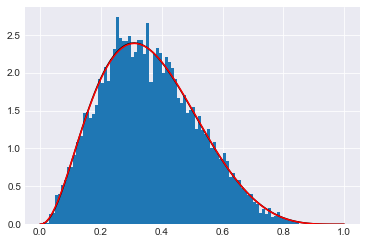

In [13]:
# Play around with these values.
tnow = 100.0
model0 = (400.0, 4.0, 1.0)  # WLOG, leave t=1.0 alone.
obs = False


# Compute the updates.
alpha0, beta0, t0 = model0
delta = tnow / t0
if obs:
    # This one is simple.
    alpha1 = alpha0 + delta
    beta1 = beta0
    t1 = t0
else:
    # This one is hard.
    m1, m2, var = posterior_moments(model0, tnow, obs)
    res = match_moments_bd(m1, m2, model0, tnow)
    alpha1, beta1, t1 = res.model
    print(res.cost)

# This is our updated model.
model1 = (alpha1, beta1, t1)

print(f'Old Model: {model0!r}')
print(f'New Model: {model1!r}')

plt.hist(simulate_posterior(model0, tnow, obs, 10000), bins=np.linspace(0.0, 1.0, 101), density=True);
plot_genbeta1(model1, tnow);
plot_posterior_pdf(model0, tnow, obs);

# Tabulate higher moments for comparison
ns = np.arange(1, 21)
momdf = pandas.DataFrame(dict(posterior=posterior_nmoments(model0, tnow, obs, ns),
                              approximation=genbeta1_nmoments(alpha1, beta1, tnow / t1, ns)),
                         index=ns)
momdf

Cool! It looks like fitting just the first two moments seems to do the job pretty well.

Let's check how good our approximation is systematically.
Let's try all combinations of low/high `alpha`, `beta`, and `delta`.

In [14]:
rows = []
for alpha0 in [2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 40.0, 100.0, 200.0, 400.0]:
    for beta0 in [2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 40.0, 100.0, 200.0, 400.0]:
        for delta in [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1.0, 1.1, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 100.0, 1000.0]:
            prior = (alpha0, beta0, 1.0)
            m1, m2, _ = posterior_moments(prior, delta, False)
            res = match_moments_bd(m1, m2, prior, delta)
            alpha1, beta1, t1 = res.model
            delta1 = delta / t1
            gb1_m1, gb1_m2, _ = genbeta1_moments(alpha1, beta1, delta1)
            rows.append([alpha0, beta0, delta, m1, m2, alpha1, beta1, delta1, gb1_m1, gb1_m2, res.cost])
df = pandas.DataFrame(data=rows, columns=['alpha0', 'beta0', 'delta', 'm1', 'm2', 'alpha1', 'beta1', 'delta1', 'gb1_m1', 'gb1_m2', 'cost'])
df

/home/rkern/.edm/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in expm1


,alpha0,beta0,delta,m1,m2,alpha1,beta1,delta1,gb1_m1,gb1_m2,cost
0,2.0,2.0,0.001,9.987347e-01,9.974716e-01,2.0,17.446867,0.000503,9.987348e-01,9.974713e-01,3.691638e-14
1,2.0,2.0,0.010,9.874684e-01,9.751479e-01,2.0,8.431584,0.006732,9.874805e-01,9.751417e-01,9.266308e-11
2,2.0,2.0,0.100,8.856952e-01,7.883341e-01,2.0,3.097081,0.112258,8.856952e-01,7.883341e-01,6.231569e-19
3,2.0,2.0,0.200,7.918552e-01,6.381251e-01,2.0,3.088829,0.220515,7.918552e-01,6.381251e-01,1.104193e-18
4,2.0,2.0,0.500,5.909091e-01,3.787879e-01,2.0,3.056994,0.527390,5.909091e-01,3.787879e-01,6.868798e-19
5,2.0,2.0,0.900,4.293042e-01,2.236083e-01,2.0,3.011089,0.908318,4.293042e-01,2.236083e-01,1.689092e-19
6,2.0,2.0,1.000,4.000000e-01,2.000000e-01,2.0,3.000000,1.000000,4.000000e-01,2.000000e-01,2.792598e-31
7,2.0,2.0,1.100,3.738065e-01,1.800061e-01,2.0,2.989181,1.090548,3.738065e-01,1.800061e-01,8.280379e-18
8,2.0,2.0,1.500,2.923077e-01,1.242604e-01,2.0,2.948957,1.443321,2.923077e-01,1.242604e-01,7.635264e-22
9,2.0,2.0,2.000,2.244898e-01,8.503401e-02,2.0,2.905569,1.868043,2.244898e-01,8.503403e-02,3.953479e-16


That's not bad!

In [15]:
df.cost.max()

5.7732025370127985e-09

In [16]:
df.loc[df.cost.idxmax()]

alpha0    4.000000e+02
beta0     2.000000e+00
delta     1.000000e-03
m1        9.999926e-01
m2        1.000052e+00
alpha1    4.000000e+02
beta1     1.967851e+01
delta1    5.585594e-04
gb1_m1    9.999731e-01
gb1_m2    9.999463e-01
cost      5.773203e-09
Name: 1440, dtype: float64

So in the worst cases, good to about 3-4 decimal places for the moments. That's pretty reasonable.

## Telescoping Half-Life

Let's see if we can try to maintain a reasonable time constant by setting the time constant to the estimated half-life.

In [8]:
def estimate_half_life(model, quantile=0.5):
    """Robust half-life (or quantile-life) estimation.
    
    Use a root-finding routine in log-delta space to find the delta that
    will cause the GB1 distribution to have a mean of the requested quantile.
    Because we are using well-behaved normalized deltas instead of times, and
    owing to the monotonicity of the expectation with respect to delta, we can
    quickly scan for a rough estimate of the scale of delta, then do a finishing
    optimization to get the right value.
    """
    alpha, beta, t0 = model
    Bab = special.beta(alpha, beta)
    
    def f(lndelta):
        mean = special.beta(alpha + np.exp(lndelta), beta) / Bab
        return mean - quantile

    # Scan for a bracket.
    bracket_width = 6.0
    blow = -bracket_width / 2.0
    bhigh = bracket_width / 2.0
    flow = f(blow)
    fhigh = f(bhigh)
    while flow > 0 and fhigh > 0:
        # Move the bracket up.
        blow = bhigh
        flow = fhigh
        bhigh += bracket_width
        fhigh = f(bhigh)
    while flow < 0 and fhigh < 0:
        # Move the bracket down.
        bhigh = blow
        fhigh = flow
        blow -= bracket_width
        flow = f(blow)

    assert flow > 0 and fhigh < 0

    sol = optimize.root_scalar(f, bracket=[blow, bhigh])
    t1 = np.exp(sol.root) * t0
    return t1

47.54175740013218 47.541757400170184 0.13216098167718796


/home/rkern/git/ebisu/ebisu/alternate.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  cdfPercentile = lambda p: betainc(alpha, beta, p**(1 / dt)) - percentile


,gb1,beta
1,0.500000,0.500000
2,0.252602,0.252602
3,0.128848,0.128903
4,0.066315,0.066423
5,0.034418,0.034552
6,0.018005,0.018139


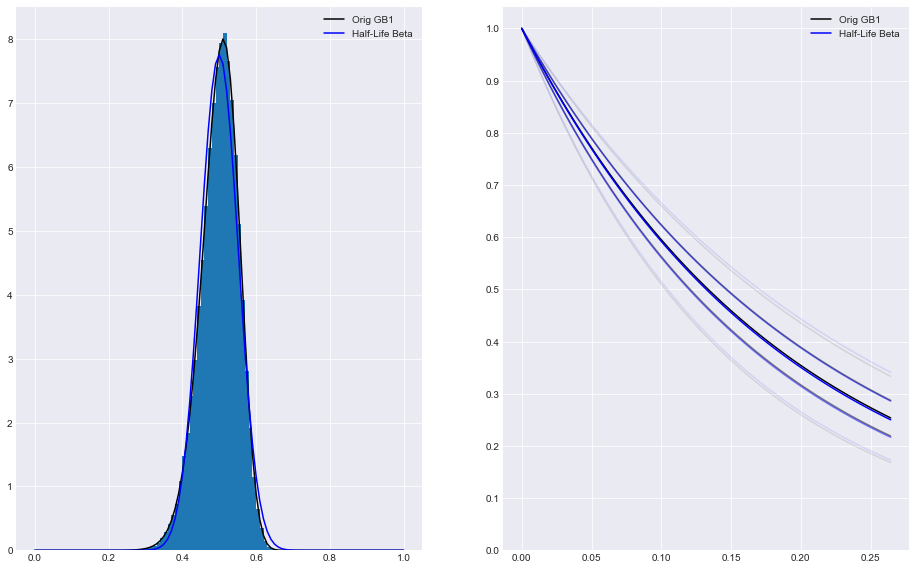

In [26]:
model0 = (2.0, 300.0, 1.0)
th = estimate_half_life(model0, 0.5)
m = ebisu.predictRecall(model0, th)
v = ebisu.predictRecallVar(model0, th)
alpha1, beta1 = ebisu.ebisu._meanVarToBeta(m, v)
model1 = (alpha1, beta1, th)


def compare_moments(model0, n):
    """Tabulate the first n moments of both approximations.
    """
    alpha0, beta0, t0 = model0
    th = estimate_half_life(model0, 0.5)
    m = ebisu.predictRecall(model0, th)
    v = ebisu.predictRecallVar(model0, th)
    delta0 = th / t0
    alpha1, beta1 = ebisu.ebisu._meanVarToBeta(m, v)
    model1 = (alpha1, beta1, th)
    ns = np.arange(1, n+1)
    gb1_ms = genbeta1_nmoments(alpha0, beta0, delta0, ns)
    beta_ms = genbeta1_nmoments(alpha1, beta1, 1.0, ns)
    df = pandas.DataFrame(dict(gb1=gb1_ms, beta=beta_ms), index=ns)
    return df

with plt.style.context({'figure.figsize': (16.0, 10.0)}):
    plt.subplot(1, 2, 1)
    plot_genbeta1(model0, th, label='Orig GB1')
    plot_genbeta1(model1, th, color='blue', label='Half-Life Beta')
    plt.hist(simulate_probs(model0, th, 100000), bins=np.linspace(0.0, 1.0, 101), density=True);
    plt.legend();
    plt.subplot(1, 2, 2)
    ts = np.linspace(0.0, 2*th, 101)
    plot_decay(model0, ts, label='Orig GB1')
    plot_decay(model1, ts, color='blue', label='Half-Life Beta')
    plt.yticks(np.linspace(0.0, 1.0, 11))
    plt.legend();

momdf = compare_moments(model0, 6)
print(alpha1, beta1, th)
momdf

Okay, so the higher moments start to diverge when `beta >> alpha`, but even so, the approximation is pretty good.